# 설정
먼저 몇 개의 모듈을 임포트 한다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비한다. 또한 파이썬 버전이 3.5 이상인지 확인한다.

In [1]:
# 파이썬 >= 3.5 필수
import sys
assert sys.version_info >= (3, 5)                                                       

# 사이킷런 >= 0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래픽 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension = "png", resolution = 300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extension, dpi = resolution)


## 3.1 MNIST

In [2]:
# MNIST 데이터 내려받기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False)
mnist.keys()  # 사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖는다.

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [17]:
# 살펴보기

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

70000 개의 이미지가 있고 각 이미지에는 784개의 특성(이미지가 28x28 픽셀이기 떄문에)이 있다는 의미  
이때 특성이란 단순히 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

In [18]:
y.shape

(70000,)

In [19]:
28*28

784

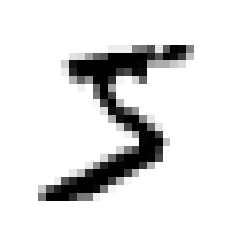

In [20]:
# 데이터셋에서 이미지 하나를 확인해 본다.
# 샘플의 특성 벡터를 추출해서 28*28 배열로 크기를 바꾸고 맷플롯립의 imshow( )함수로 그려본다.

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)  #.reshape() 함수로 1차원배열을 2차원 배열로 바꾼다.
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")

plt.show()

In [21]:
# 위 그림의 레이블 확인

y[0]

'5'

In [22]:
# 레이블은 문자열이다.
# 머신러닝 알고리즘에서는 숫자를 기대하므로 정수로 변환한다.

y = y.astype(np.uint8)

In [23]:
# MNIST 데이터셋에 들어 있는 다른 숫자이미지들도 출력

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
                interpolation = "nearest")
    plt.axis("off")

In [24]:
# 숫자 그림을 위한 추가 함수
# 이해못함

def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
    image = np.concatenate(row_images, axis = 0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

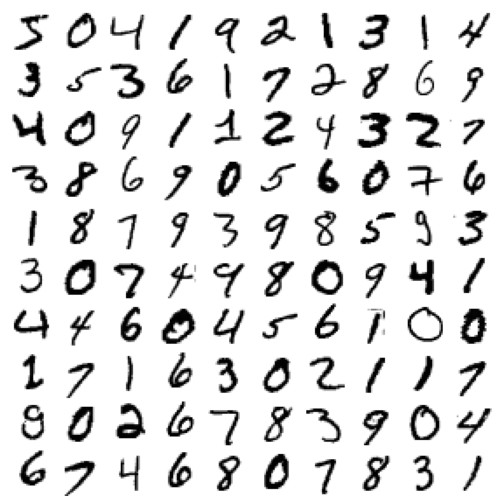

In [25]:
plt.figure(figsize = (9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)

plt.show()

In [26]:
# MNIST 데이터셋은 훈련세트와 테스트세트가 이미 나누어져 있다.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

In [27]:
# 분류 작업을 위해 타깃 벡터를 만든다.

y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

In [28]:
# 분류 모델 중 확률적 경사 하강법 분류기를 선택
# SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시킨다.

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)  # 결과를 이후에 똑같이 재현하기 위해 random_state 매개변수를 지정해 준다.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

모델 훈련을 완료했고 이제 예측을 해본다.

In [29]:
# 이전에 만들어둔 숫자5 이미지 감지해보기

sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 추측했다는 의미 "True"

## 3.3 성능 측정
### 3.3.1 교차 검증을 사용한 정확도 측정

In [30]:
# cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가한다.

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

출력 결과를 보면 모두 95% 이상의 높은 정확도를 보이는 것을 알 수 있다.

In [ ]:
# 사이킷런의 cross_val_score()와 같은 기능을 수행하는 교차 검증을 직접 구현한 경우

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle = True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해 본다.

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [ ]:
# 모델의 정확도 추측해 보기

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

출력해 보면 마찬가지로 높은 정확도를 띈다.  
애초에 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님' 으로 예측하면 정확히 맞출 확률이 90% 다.  
이처럼 **불균형한 데이터셋** (어떤 클래스가 다른 것보다 월등히 많은 경우)을 다룰 때는 정확도는 분류기의 성능 측정 지표로 선호되지 않는다.  

### 3.3.2 오차 행렬
분류기의 성능을 평가하는 더 좋은 방법.  
예를 들어 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

In [ ]:
# 오차 행렬을 만들려면 실제 타깃과 비교할 예측값이 필요한데 이때 테스트 세트로 예측값을 만드는 것이 아니라
# cross_val_predict() 메서드를 사용한다.

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

# cross_val_predict()는 교차 검증을 수행하고 각 테스트 폴드에서 얻은 예측을 반환한다.
# 즉 훈련 세트의 모든 샘플에 대한 예측을 얻게 된다.

In [ ]:
# 오차 행렬 만들기

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

1행 : 진짜 음성 ('5 아님'을 '5 아님'으로 분류)  |  거짓 양성 ('5 아님'을 '5' 라고 분류)  
2행 : 거짓 음성 (''5'를 '5 아님'으로 분류)  | 진짜 양성 ('5'를 '5'라고 분류)  
완벽한 분류기라면 오차 행렬의 주대각선만 0이 아닌 값을 가진다.

In [ ]:
y_train_5.shape

(60000,)

In [ ]:
# 완벽한 분류기인 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

# 전부 진짜양성 혹은 진짜음성에만 해당

array([[54579,     0],
       [    0,  5421]])

오차 행렬이 많은 정보를 제공해주지만 더 요약된 지표가 필요할 때도 있다.  
**양성 예측의 정확도**  
이를 분류기의 **정밀도**라고 한다.  
정밀도는 **재현율**이라는 또 다른 지표와 같이 사용하는 것이 일반적이다.  
### 3.3.3 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # 정밀도

0.8370879772350012

즉 **5로 판별된 이미지 중** 83.7%만 정확하다.

In [ ]:
cm = confusion_matrix(y_train_5, y_train_pred)  # 오차 행렬을 만들고
cm[1, 1] / (cm[0, 1] + cm[1, 1])  # 직접 숫자를 대입해서 계산해보니 위의 메서드로 한 값과 동일하다.

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)  # 재현율

0.6511713705958311

**전체 숫자 5**에서 65.1%만 감지했다.

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

정밀도와 재현율을 $F_1$ 점수 라고 하는 하나의 숫자로 표현할 수 있다.  
$F_1$ 점수는 정밀도와 재현율의 조화 평균이다.

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

In [ ]:
# 사이킷런에서 임곗값을 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.
# predict() 대신 decision_function()을 호출하면 각 샘플의 점수를 얻을 수 있다.
# 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

y_scores = sgd_clf.decision_function([some_digit])  # 결정 함수로 샘플의 점수 계산
y_scores  

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

# 임곗값이 0이기 때문에 위 코드는 predict() 메서드와 같은 결과 True 를 반환한다.
# 즉 predict()도 0보다 큰 경우를 양성을 예측한다.
# 아래에서는 임곗값을 높게 설정해 본다.

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

# 임곗값을 높이면 재현율이 줄어드는 것을 결과로 확인할 수 있다.
# "이미지가 실제로 숫자 5이고 임곗값이 0일 때는 분류기가 이를 감지했지만, 임곗값을 높이면 놓치게 된다"

array([False])

In [ ]:
# 적절한 임곗값을 찾으려면 cross_val_predict() 로 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
# 이때 예측 결과가 아니라 결정 점수를 반환 받는다.
# 이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산할 수 있다.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

# 예측 결과가 아니라 결정 점수를 반환

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

#  임곗값의 함수로 정밀도와 재현율을 그려본다.

그림 저장: precision_recall_vs_threshold_plot


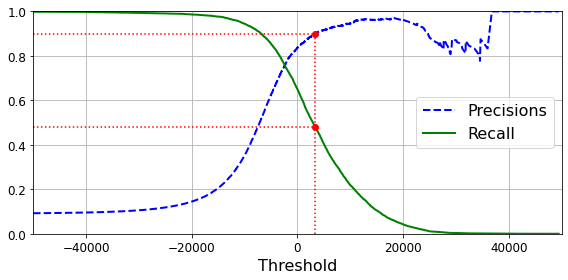

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precisions", linewidth = 2)
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
    plt.legend(loc = "center right", fontsize = 16)
    plt.xlabel("Threshold", fontsize = 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

그림 저장: precision_vs_recall_plot


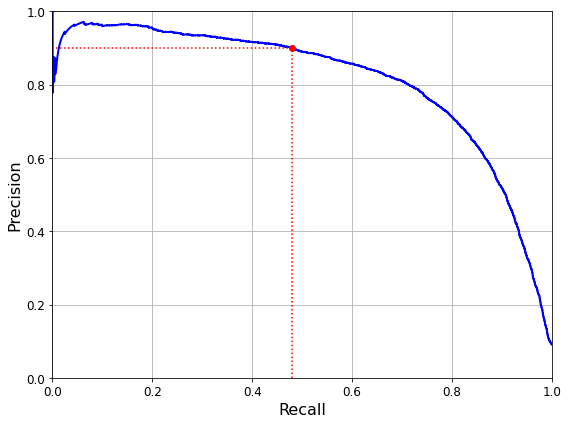

In [ ]:
# 좋은 정밀도/재현율 트레이드오프를 선택하는 방법은 재현율에 대한 정밀도 곡선 그래프를 그려보는 것 
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

# 아래의 그래프를 보면 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작한다.
# 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.

In [ ]:
# 최소한 90% 정밀도가 되는 가장 낮은 임계값을 찾아보자
# np.argmax()는 최댓값의 첫 번째 인덱스를 반환한다.

threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [ ]:
# 훈련 세트에 대한 예측을 만들려면 분류기의 predict()메서드 대신 아래의 코드를 실행한다.

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
# 위의 예측에 대한 정밀도와 재현율을 확인해 보자

precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

정밀도 90% 를 달성한 분류기를 만들었다.  
하지만 이때 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다.

### 3.3.5 ROC 곡선
재현율 = "진짜 양성 비율"  
ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프다.

In [ ]:
# roc_curve()함수로 여러 임곗값에서의 TPR과 FRP를 계산할 수 있다.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)  # y_score의 값이 임곗값보다 크면 양성 클래스, 아니면 음성 클래스

그림 저장: roc_curve_plot


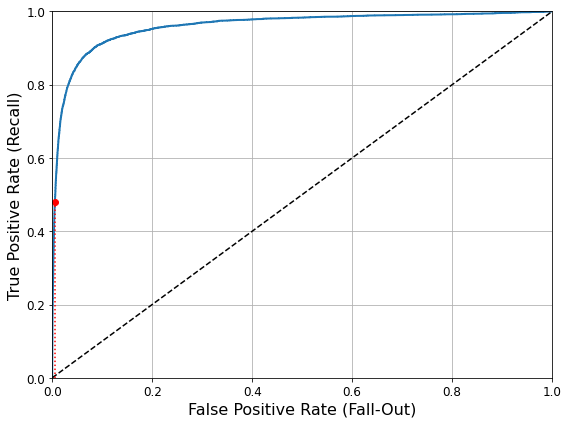

In [ ]:
# TPR에 대한 FPR 곡선

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0 ,1], 'k--')  # 대각 점선
    plt.axis([0, 1, 0, 1])  # 축의 범위 지정
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize = 16)  # 축 이름
    plt.ylabel('True Positive Rate (Recall)', fontsize = 16)
    plt.grid(True)  # 그리드 추가

plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("roc_curve_plot")
plt.show()

# 출력된 그래프에서 점선은 완전한 랜덤 분류기의 ROC 곡선을 나타낸다.
# 좋은 분류기는 이 점선에서 최대한 멀리 떨어져야 한다.

In [ ]:
# 사이킷런의 ROC의 AUC를 계산하는 함수

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜서 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해 본다.  
먼저 훈련세트의 샘플에 대한 점수를 알아야 한다.  
RandomForestClassifier에는 decision_function() 이 없기 때문에 predict_proba()메서드를 이용한다.  
predict_proba()메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.  

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, 
                                    method = "predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1]  # 점수 대신 양성 클래스의 확률을 넣어준다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

그림 저장: roc_curve_comparison_plot


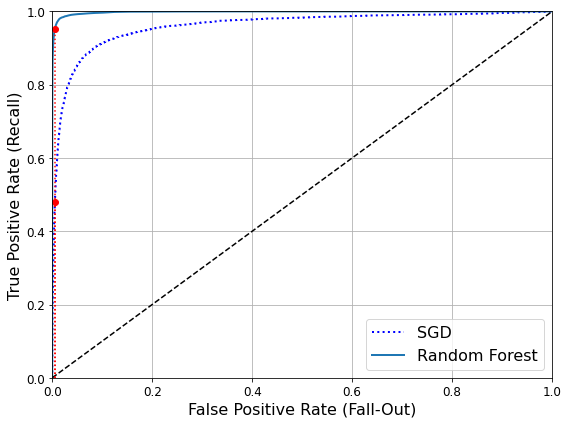

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc = "lower right", fontsize = 16)
save_fig("roc_curve_comparison_plot")
plt.show()

위의 그래프를 보면 RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까우며 SGDClassifier 보다 좋아 보인다.  
당연히 ROC AUC 점수도 훨씬 높다.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

99% 의 정밀도

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

86.6%의 재현율   

## 3.4 다중 분류
가장 먼저 서포트 벡터 머신 분류기를 테스트해 본다.

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto", random_state = 42)
svm_clf.fit(X_train[:1000], y_train[:1000])  # 0에서 9까지의 원래 타깃클래스(y_train)으로 SVC를 훈련
svm_clf.predict([some_digit])  # 훈련한 모델로 예측해 본다.

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

decision_function() 는 샘플 당 10개의 점수(0~9니까)를 반환한다.  
위의 결과를 보면 클래스 5 의 점수가 가장 높다. 

In [ ]:
np.argmax(some_digit_scores)

# np.argmax 는 인자로 받은 배열에서 최댓값의 인덱스를 반환한다.

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

# classes 배열에 있는 각 클래스의 인덱스가 클래스 값 자체와 같다. <- 근데 이런 경우는 드물다.

5

SVC를 사용하면 사이킷런 **내부에서 자동으로 OvO 전략을 사용**해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다.  
SVC기반으로 OvR 전략을 사용하는 다중 분류기의 코드는 아래와 같다.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma = "auto", random_state = 42))
ovr_clf.fit(X_train[:1000], y_train[:1000])  # 훈련 
ovr_clf.predict([some_digit])  # 예측

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

이번엔 SGDClassifier.

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 떄문에 별도로 OvR 이나 OvO 를 적용할 필요가 없다.  
decision_function()을 통해 SGD 분류기가 클래스마다 부여한 점수를 확인할 수 있다.

In [ ]:
sgd_clf.decision_function([some_digit])

# 클래스 3의 점수가 가장 높다.
# 위코드의 출력에서 [3] 이 나왔듯 .!

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

교차검증으로 분류기를 평가해 본다.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")  # 분류기 자체, 훈련 데이터, 타깃 데이터, 폴드 갯수 등 인자로 넣어주기

array([0.87365, 0.85835, 0.8689 ])

모든 테스트 폴드에서 84% 이상을 받았다. 점수가 나쁘지는 않지만 성능을 더 높일 여지는 있다.  
예를들어 간단하게 입력의 스케일을 조정해서 정확도를 높여본다.  

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

성능이 전부 89 이상이 된 것을 확인할 수 있다.

## 3.5 에러 분석

In [ ]:
# 우선 cross_val_preidct()로 예측을 만들고 confusion_matrix()를 호출

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

그림 저장: confusion_matrix_plot


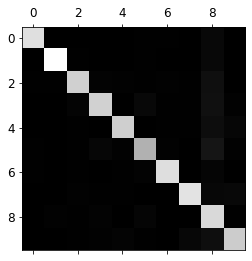

In [ ]:
# matshow() 함수를 이용해서 오차 행렬을 이미지로 표현한다.

plt.matshow(conf_mx, cmap = plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout = False)
plt.show()

In [ ]:
# 에러 비율로 비교하기 위해 각 행의 sum값으로 나눠준다.

row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

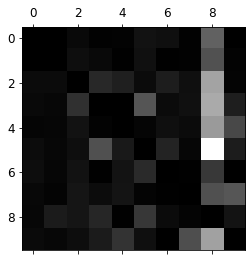

In [ ]:
# 더 잘보려고? 정답으로 맞춰버린 주대각선 부분은 중요하지 않으니까 주대각선은 전부 0으로 채우고 그래프를 다시 그린다.

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

주대각선을 0으로 처리해줘서 에러를 더 잘 볼 수 있다.

## 3.6 다중 레이블 분류
분류기가 샘플마다 여러 개의 클래스를 출력해야 하는 경우.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # 두 개의 타깃 레이블이 담긴 배열

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)  

KNeighborsClassifier()

In [ ]:
# 예측

knn_clf.predict([some_digit])

array([[False,  True]])

## 3.7 다중 출력 분류

In [ ]:
# MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 잡음 추가하기

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

그림 저장: noisy_digit_examplt_plot


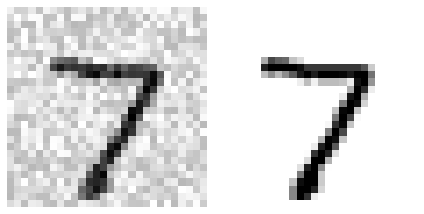

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_examplt_plot")
plt.show()

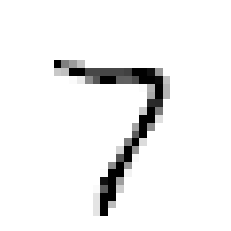

In [ ]:
# 분류기를 훈련시켜서 위의 이미지를 깨끗하게 만들어 보자

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## 추가 내용
### 더미 (즉 랜덤) 분류기

In [ ]:
from sklearn.dummy import DummyClassifier

dmy_clf = DummyClassifier(strategy = 'prior')
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, method = "predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

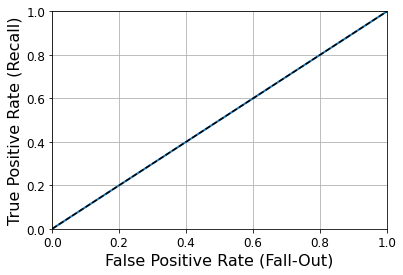

In [ ]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

# 랜덤이라서 AOC?가 딱 0.5가 되게 그려진건가

### KNN 분류기

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_knn_pred)

0.9714

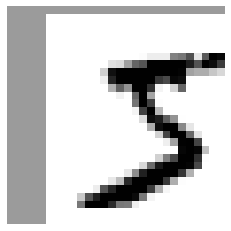

In [ ]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit_array, dx, dy, new = 0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval = new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new = 100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, dx = dx, dy = dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [ ]:
# 훈련 세트 만들었으니 fit으로 모델 만들기

knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

# 늘어난 훈련 세트로 만든 모델로 예측한 것의 점수가 전보다 높아졌다 !

0.9763

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

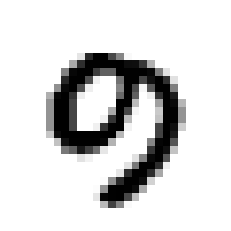

In [ ]:
plot_digit(ambiguous_digit)

## 3.8 연습문제

### 1. 
MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요.  
힌트 : KNeighborsClassifier , 그리드 탐색

In [ ]:
# X_train, X_test, y_train, y_test  
from sklearn.metrics import accuracy_score

kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)
y_pred = kn_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9688


그리드 써치는 아직 적용하지 않았는데 꽤 높게 나왔다.  
제대로 한 건 맞나  
아직 아무것도 수정하지 않은 상태의 하이퍼파라미터를 우선 확인해 본다.

In [ ]:
print(kn_clf.weights, kn_clf.n_neighbors)

uniform 5


KNN 분류기의 weights : uniform, distance  
이때 uniform이 디폴트.  
distance로도 돌려본다.  
n_neighbors는 5 와 비슷한 값들로 넣어본다.  

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'weights' : ["uniform", "distance"],
    'n_neighbors' : [3, 4, 5]
}]

kn_clf = KNeighborsClassifier()
grid_search  = GridSearchCV(kn_clf, param_grid, cv = 5, verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  37.7s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  39.0s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  33.3s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  32.4s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  32.4s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  32.6s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  32.5s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  32.5s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  33.2s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  32.5s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  36.8s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [ ]:
grid_search.best_score_

0.9716166666666666

In [ ]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

### 2. 
MNIST 이미지를 (왼, 오, 아래, 위) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수 만들고 훈련 세트의 각 이미지에 적용하여 훈련 세트에 추가.  
이 확장된 데이터셋에서 문제1에서 찾은 모델을 훈련시키고 테스트 세트에서 정확도를 측정.  
모델의 성능이 더 높아졌는지 확인해라.  
이처럼 인위적으로 훈련 세트를 늘리는 기법을 **데이터 증식** 또는 **훈련 세트 확장**이라고 한다.

In [ ]:
X_train.shape

(60000, 784)

60000개의 이미지와 28x28 픽셀

In [6]:
# 책 풀이
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval = 0, mode="constant")
    return shifted_image.reshape([-1])

_내가_    
한 픽셀 이동시킬 수 있는 함수
- 행 하나를 맨 첫 줄 / 마지막 줄에 추가 : 아래, 위 이동
- 열 하나를 맨 왼쪽 / 오른쪽에 추가 : 오른쪽, 왼쪽 이동

In [ ]:
import copy
import numpy as np

X_train_copy = copy.copy(X_train)

In [ ]:
# 추가해줄 공백 행과 열 저장해두기
sample = X_train_copy[0].reshape(28, 28)
rows = copy.copy(sample[0])

우선 가장 첫 번째 숫자 하나만으로 위/아래/왼/오 이동 구현을 해봤다.

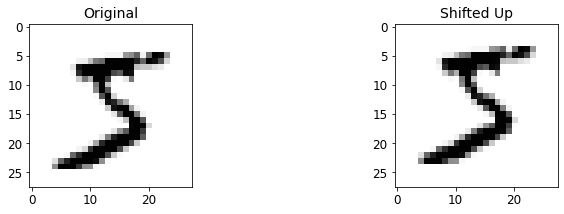

In [ ]:
# 1. 위로 이동
plt.figure(figsize = (12, 3))
plt.subplot(121)  
plt.title("Original", fontsize = 14)
plt.imshow(sample, interpolation = "nearest", cmap = "Greys")

shifted_up = np.delete(sample, 0, axis = 0)
shifted_up = np.append(shifted_up, [rows], axis = 0)
plt.subplot(122)
plt.title("Shifted Up", fontsize = 14)
plt.imshow(shifted_up, interpolation = "nearest", cmap = "Greys")

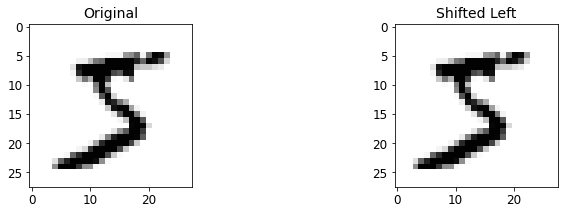

In [ ]:
# 2. 왼쪽 이동
plt.figure(figsize = (12, 3))
plt.subplot(121)  
plt.title("Original", fontsize = 14)
plt.imshow(sample, interpolation = "nearest", cmap = "Greys")

shifted_left = np.delete(sample, 0, axis = 1)
shifted_left = np.append(shifted_left, [[rows[0]] for _ in range(len(sample))], axis = 1)
plt.subplot(122)
plt.title("Shifted Left", fontsize = 14)
plt.imshow(shifted_left, interpolation = "nearest", cmap = "Greys")

이제 전체 데이터에 대해 적용해 주면 된다.  
너무 오래 걸려서 책 풀이에 나온 함수를 이용해야겠다.

해야할 것  
- 전체 X_train에 대해 네 방향으로의 shifted_image 함수를 적용 + 결괏값을 y_train에 저장까지  (이때 X_test & y_test는 건들지 않고)
- 확장된 데이터셋으로 문제1에서 한 과정 다시 하고 결과 비교하기


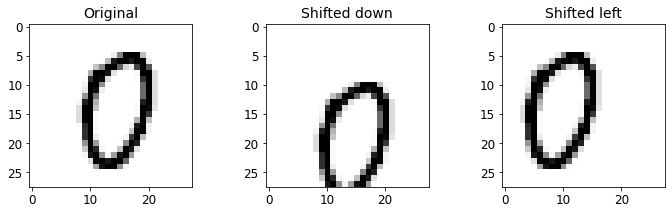

In [9]:
# shift_image함수가 잘 동작하는 것을 알 수 있다.
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize = (12, 3))  # 그래프 격자가 위치할 기본 틀
plt.subplot(131)  # 1행 3열의 첫번째
plt.title("Original", fontsize = 14)
plt.imshow(image.reshape(28, 28), interpolation = "nearest", cmap = "Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize = 14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation = "nearest", cmap = "Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize = 14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation = "nearest", cmap = "Greys")
plt.show()

_plt.imshow() :  
2차원 배열 객체를 색깔로 표시해 준다.  
interpolation은 보간법 & nearest는 가장 고해상도인 보간법_  

In [10]:
# 새로운 데이터셋 변수를 선언
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [13]:
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
  for image, label in zip(X_train, y_train):
    X_train_augmented.append(shift_image(image, dx, dy))
    y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [14]:
# 확장된 데이터들의 순서를 섞어준다.
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]  
y_train_augmented = y_train_augmented[shuffle_idx]

In [31]:
# 우선 그리드써치 하지 않고
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train_augmented, y_train_augmented)
y_pred = kn_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:217: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


결과가 이상하다.  
어디가 틀린건지

In [ ]:
# 그리드써치로 최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

param_grid = [{
    'weights' : ["uniform", "distance"],
    'n_neighbors' : [3, 4, 5]
}]

kn_clf = KNeighborsClassifier()
grid_search  = GridSearchCV(kn_clf, param_grid, cv = 5, verbose = 3)
grid_search.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.984 total time=12.5min
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.984 total time=12.4min
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.984 total time=12.4min
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.984 total time=12.4min
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.984 total time=12.4min
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.985 total time=12.5min
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.985 total time=12.4min
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.985 total time=12.3min
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.985 total time=12.3min
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.985 total time=12.3min
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.982 total time=13.6min
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

정확도가 높아진 것을 알 수 있다.

### 3. 
타이타닉 데이터셋

In [ ]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path = TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있다.  
그러나 테스트 데이터는 레이블을 가지고 있지 않다. <- 무슨말 ..?

In [ ]:
# 상위 몇 개의 열만 우선 살펴보자

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived : 타깃 !  

In [ ]:
# 누락된 데이터가 얼마나 되는지 살펴보자

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


살펴보면 Cabin은 null값이 너무 많다. -> Cabin 말고 다른 것들을 활용하자  
Name과 Ticket 속성도 값을 non-null이 많긴 하지만 Dtype 이 숫자가 아니기 때문에
숫자로 변환하는 것이 까다로울 수 있다.

In [ ]:
# 통계치를 살펴보자

train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# 타깃이 0과 1로 이루어졌는지 확인하기

train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
# 범주형 특성들을 확인하자

train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

전처리 파이프라인을 만들어 보자

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names]


숫자 특성을 위한 파이프라인 만들기

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("Imputer", SimpleImputer(strategy = "median"))
])

In [ ]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로 된 범주형 열을 위해 별도의 Imputer 클래스가 필요하다.  

In [ ]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index = X.columns)
        return self
    def transform(self, X, y = None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

범주형 특성을 위한 파이프라인 만들기

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse = False)),
])

In [ ]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

마지막으로 숫자와 범주형 파이프라인을 연결한다.

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list = [
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
])

원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

레이블을 가져온다.

In [ ]:
y_train = train_data["Survived"]

이제 분류기를 훈련시키자. 먼저 SVC로  

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma = "auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

모델 훈련을 완료했고 이걸로 테스트 세트에 대한 예측 만들기

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

예측을 완료했지만 교차 검증으로 모델이 얼마나 좋은지 평가해 보자

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores.mean()

0.7329588014981274

만족스러운 수치는 아니다.  
RandomForestClassifier를 적용해 보자

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv = 10)
forest_scores.mean()

0.8126466916354558

이전보다 꽤 높아졌다.

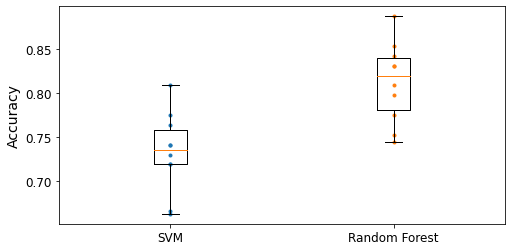

In [ ]:
plt.figure(figsize = (8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels = ("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize = 14)
plt.show()

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


### 4. 
스팸 분류기 만들기